In [1]:
#############################################
# 0. 기본 설정 & 하이퍼파라미터
#############################################
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# node4에서 쓰던 이미지 폴더 경로로 맞춰줘
dataset_dir = "~/work/data_augmentation/data/Images/"

# 메모리·시간 고려해서 작은 값으로 시작
BATCH_SIZE = 4       # 필요하면 2로 줄여도 됨
EPOCHS = 2           # 먼저 2ep로 테스트 → 나중에 5, 10으로 늘리기

Device: cuda


In [2]:
#############################################
# 1. Dataset / Transform 정의
#############################################

# (1) 기본 전처리: Resize + ToTensor + Normalize
def normalize_and_resize_img():
    return transforms.Compose([
        transforms.Resize((128, 128)),   # 224x224 → 128x128로 줄여서 가볍게
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ])

# (2) 기본 Augmentation: 좌우반전 + 밝기조절
def basic_augment():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2),
    ])

# (3) ImageFolder로 전체 데이터 불러오기 (transform은 나중에 쓸 거라 None)
full_dataset = ImageFolder(root=dataset_dir, transform=None)

total_size = len(full_dataset)
train_size = int(0.583 * total_size)  # node4 비율
val_size = total_size - train_size
ds_train, ds_val = random_split(full_dataset, [train_size, val_size])

NUM_CLASSES = len(full_dataset.classes)
print("클래스 개수:", NUM_CLASSES)

# (4) 하나의 Subset(ds_train)을 서로 다른 transform으로 감싸기 위한 래퍼
class WrappedSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]   # img: PIL.Image, label: int
        if self.transform is not None:
            img = self.transform(img)
        return img, label

# (5) transform 조합 만들기
base_transform = normalize_and_resize_img()
aug_transform = transforms.Compose([
    *basic_augment().transforms,
    *base_transform.transforms,
])

# (6) 4가지 실험 중 “데이터셋 관점”에서는 2가지:
#   - No Aug: base_transform만 사용
#   - Basic Aug: aug_transform 사용
train_noaug_ds = WrappedSubset(ds_train, transform=base_transform)
train_basic_ds = WrappedSubset(ds_train, transform=aug_transform)
val_ds        = WrappedSubset(ds_val,   transform=base_transform)

train_loader_noaug = DataLoader(train_noaug_ds,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                num_workers=0)  # CPU 환경이니 0으로
train_loader_basic = DataLoader(train_basic_ds,
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                num_workers=0)
val_loader = DataLoader(val_ds,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=0)

print("DataLoaders ready.")


클래스 개수: 120
DataLoaders ready.


In [3]:
#############################################
# 2. MixUp / CutMix + Loss
#############################################

def onehot(labels, num_classes=NUM_CLASSES):
    if isinstance(labels, torch.Tensor):
        return torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
    else:
        return torch.nn.functional.one_hot(torch.tensor(labels),
                                           num_classes=num_classes).float()

def categorical_crossentropy(logits, target_onehot):
    """
    logits: (B, C), target_onehot: (B, C)
    MixUp/CutMix 같이 soft label일 때 쓰는 loss
    """
    log_probs = torch.log_softmax(logits, dim=1)
    loss = -(target_onehot * log_probs).sum(dim=1).mean()
    return loss

def mixup_batch(x, y, alpha=1.0, num_classes=NUM_CLASSES):
    if alpha <= 0:
        return x, onehot(y, num_classes)

    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a = onehot(y, num_classes)
    y_b = onehot(y[index], num_classes)
    mixed_y = lam * y_a + (1 - lam) * y_b
    return mixed_x, mixed_y

def rand_bbox(W, H, lam):
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix_batch(x, y, alpha=1.0, num_classes=NUM_CLASSES):
    if alpha <= 0:
        return x, onehot(y, num_classes)

    lam = np.random.beta(alpha, alpha)
    batch_size, C, H, W = x.size()
    index = torch.randperm(batch_size)

    bbx1, bby1, bbx2, bby2 = rand_bbox(W, H, lam)
    x_cut = x.clone()
    x_cut[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]

    lam_adjusted = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))

    y_a = onehot(y, num_classes)
    y_b = onehot(y[index], num_classes)
    mixed_y = lam_adjusted * y_a + (1 - lam_adjusted) * y_b
    return x_cut, mixed_y


In [4]:
#############################################
# 3. ResNet-50 생성 함수
#############################################

def create_resnet50(num_classes=NUM_CLASSES):
    # pretrained 안 쓰고 빈 ResNet50로 시작 (조금 더 가벼움)
    resnet50 = models.resnet50(weights=None)
    in_features = resnet50.fc.in_features
    resnet50.fc = nn.Linear(in_features, num_classes)
    return resnet50

criterion_sparse = nn.CrossEntropyLoss()  # 정수 라벨용 (No Aug, Basic Aug에서 사용)


In [5]:
#############################################
# 4. Train / Eval 함수
#############################################

def train_one_epoch(model, loader, optimizer,
                    use_mixup=False, use_cutmix=False,
                    alpha=1.0):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # ---- 여기서 MixUp / CutMix 적용 여부 결정 ----
        if use_mixup:
            inputs, targets = mixup_batch(images, labels, alpha=alpha)
            outputs = model(inputs)
            loss = categorical_crossentropy(outputs, targets)
        elif use_cutmix:
            inputs, targets = cutmix_batch(images, labels, alpha=alpha)
            outputs = model(inputs)
            loss = categorical_crossentropy(outputs, targets)
        else:
            outputs = model(images)
            loss = criterion_sparse(outputs, labels)

        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size

        # 정확도는 항상 "원래 정수 라벨" 기준으로 계산
        _, preds = outputs.max(1)
        running_correct += (preds == labels).sum().item()
        total += batch_size

    return running_loss / total, running_correct / total

def evaluate(model, loader):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion_sparse(outputs, labels)

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size

            _, preds = outputs.max(1)
            running_correct += (preds == labels).sum().item()
            total += batch_size

    return running_loss / total, running_correct / total

def train_model(model, optimizer, train_loader, val_loader,
                epochs, use_mixup=False, use_cutmix=False,
                alpha=1.0, tag=""):
    history = {"train_loss": [], "train_acc": [],
               "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer,
            use_mixup=use_mixup, use_cutmix=use_cutmix, alpha=alpha
        )
        val_loss, val_acc = evaluate(model, val_loader)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"[{tag}] Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history


In [6]:
#############################################
# 5. 네 가지 경우를 "순서대로" 학습
#############################################

histories = {}  # 각 실험의 history 저장

experiments = [
    ("NoAug",        train_loader_noaug,  False, False),  # (이름, train_loader, use_mixup, use_cutmix)
    ("BasicAug",     train_loader_basic,  False, False),
    ("Basic+MixUp",  train_loader_basic,  True,  False),
    ("Basic+CutMix", train_loader_basic,  False, True),
]

for name, train_loader, use_mixup, use_cutmix in experiments:
    print(f"\n===== {name} 학습 시작 =====")

    model = create_resnet50().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    history = train_model(
        model, optimizer,
        train_loader, val_loader,
        epochs=EPOCHS,
        use_mixup=use_mixup,
        use_cutmix=use_cutmix,
        alpha=1.0,
        tag=name
    )

    histories[name] = history

    # CPU라서 굳이 비울 필요는 없지만 형식상
    del model
    del optimizer
    print(f"===== {name} 학습 종료 =====")



===== NoAug 학습 시작 =====
[NoAug] Epoch [1/2] Train Loss: 5.2503, Train Acc: 0.0093, Val Loss: 8.5426, Val Acc: 0.0136
[NoAug] Epoch [2/2] Train Loss: 4.8427, Train Acc: 0.0136, Val Loss: 9.9489, Val Acc: 0.0218
===== NoAug 학습 종료 =====

===== BasicAug 학습 시작 =====
[BasicAug] Epoch [1/2] Train Loss: 5.2482, Train Acc: 0.0093, Val Loss: 5.6291, Val Acc: 0.0128
[BasicAug] Epoch [2/2] Train Loss: 4.8799, Train Acc: 0.0128, Val Loss: 8.0431, Val Acc: 0.0134
===== BasicAug 학습 종료 =====

===== Basic+MixUp 학습 시작 =====
[Basic+MixUp] Epoch [1/2] Train Loss: 5.2233, Train Acc: 0.0084, Val Loss: 11.1491, Val Acc: 0.0126
[Basic+MixUp] Epoch [2/2] Train Loss: 4.9050, Train Acc: 0.0098, Val Loss: 12.4542, Val Acc: 0.0118
===== Basic+MixUp 학습 종료 =====

===== Basic+CutMix 학습 시작 =====
[Basic+CutMix] Epoch [1/2] Train Loss: 5.2029, Train Acc: 0.0084, Val Loss: 8.2449, Val Acc: 0.0091
[Basic+CutMix] Epoch [2/2] Train Loss: 4.9077, Train Acc: 0.0098, Val Loss: 7.4014, Val Acc: 0.0085
===== Basic+CutMix 학습 종료 

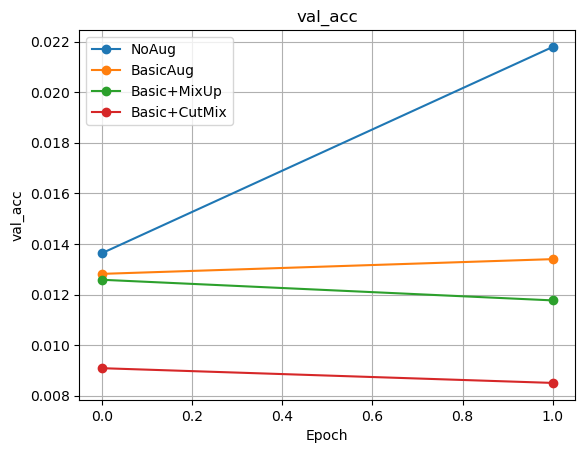

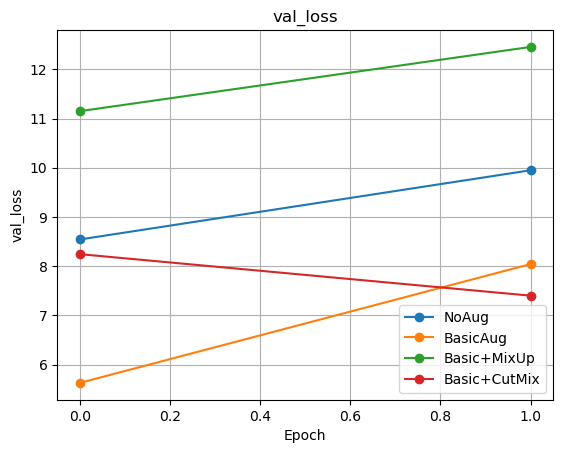


=== 최종 Val Acc 비교 ===
NoAug: 0.0218
BasicAug: 0.0134
Basic+MixUp: 0.0118
Basic+CutMix: 0.0085


In [7]:
#############################################
# 6. 결과 시각화 & 최종 비교
#############################################

def plot_histories_from_dict(histories, metric="val_acc"):
    plt.figure()
    for name, hist in histories.items():
        plt.plot(hist[metric], marker="o", label=name)
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

# 검증 정확도 곡선 비교
plot_histories_from_dict(histories, metric="val_acc")

# 검증 손실 곡선 비교
plot_histories_from_dict(histories, metric="val_loss")

# 마지막 Epoch 기준 정확도 요약 출력
print("\n=== 최종 Val Acc 비교 ===")
for name, hist in histories.items():
    print(f"{name}: {hist['val_acc'][-1]:.4f}")